## 20뉴스그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [3]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [4]:
news_df.isnull().values.any() # 데이터프레임에 null값 있는지 확인

False

In [5]:
# null은 없으나 빈 값 유무도 확인해야한다. 모든 빈 값을 null 값으로 변환하고, 다시 null값이 있는지 확인한다.
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True) # null값 제거
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [7]:
# 불용어를 제거
nltk.download('stopwords') # 불용어 다운로드
stop_words = stopwords.words('english') # 영어 불용어 저장
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/20143232/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/dlpc/python/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [9]:
# 단어 집합을 생성하고, 정수 인코딩을 진행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
print(encoded[:2]) # 상위 2개 샘플 출력

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
# 단어 집합의 크기 확인
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## 네거티브 샘플링을 통한 데이터셋 구성하기

위 과정과 같이 일반적인 전처리 과정을 거쳤다. 이제 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용한다.

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]] # 상위 10개에 대해서만 전처리 수행


In [13]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(jews (222), coral (32570)) -> 0
(soldiers (957), reports (755)) -> 1
(seem (207), story (603)) -> 1
(story (603), coded (8240)) -> 0
(media (702), statement (474)) -> 1


In [14]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


10개 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있다.

In [15]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


이 작업을 모든 뉴스그룹 샘플에 대해서 수행

In [16]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

## Skip-Gram with Negative Sampling(SGNS) 구현하기

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG


In [18]:
embed_size = 100 # 임베딩 벡터 차원은 100으로 설정

In [19]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
______________________________________________________________________________________________

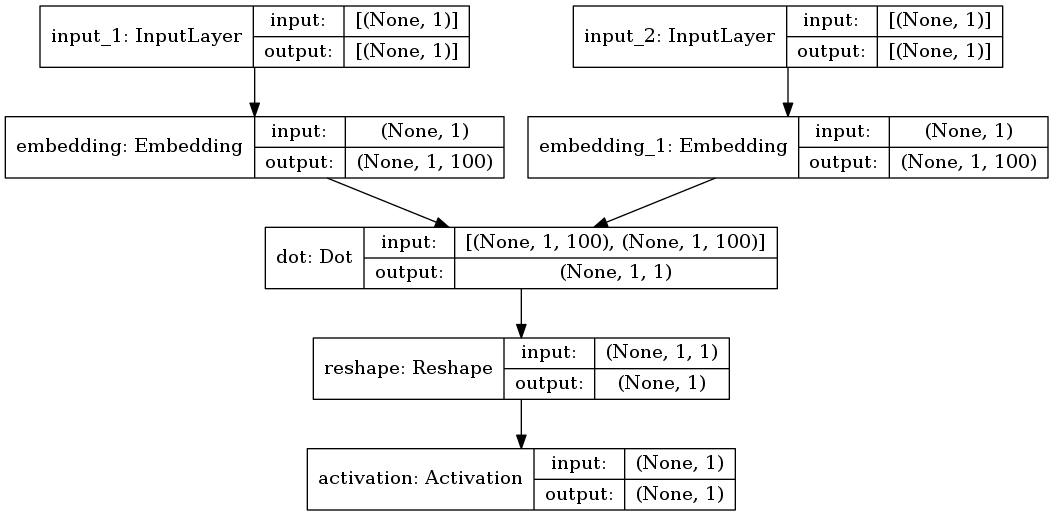

In [20]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [21]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4635.26110856235
Epoch : 2 Loss : 3668.4771690256894
Epoch : 3 Loss : 3499.1504171341658
Epoch : 4 Loss : 3292.7665440924466
Epoch : 5 Loss : 3068.914705103729


## 결과 확인하기

In [22]:
import gensim

In [23]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [25]:
w2v.most_similar(positive=['soldiers'])

[('lebanon', 0.8437274098396301),
 ('shelling', 0.8404714465141296),
 ('palestine', 0.8267177939414978),
 ('wounded', 0.8260786533355713),
 ('arabs', 0.8246393799781799),
 ('moslem', 0.8233586549758911),
 ('slaughtered', 0.8225008845329285),
 ('kuwait', 0.8211223483085632),
 ('israelis', 0.811773419380188),
 ('mainland', 0.8083171844482422)]

In [26]:
w2v.most_similar(positive=['doctor'])

[('swelling', 0.600212812423706),
 ('prophylaxis', 0.5922632217407227),
 ('cardiac', 0.5872841477394104),
 ('physician', 0.5849272012710571),
 ('wash', 0.5739371180534363),
 ('laugh', 0.5620549917221069),
 ('oral', 0.54355788230896),
 ('beforehand', 0.5395854711532593),
 ('migraine', 0.5377948880195618),
 ('analgesics', 0.536381185054779)]

In [27]:
w2v.most_similar(positive=['police'])

[('scenario', 0.5932937860488892),
 ('arms', 0.5835854411125183),
 ('lawyer', 0.5549371242523193),
 ('agencies', 0.5454394817352295),
 ('redress', 0.5372000932693481),
 ('ethnic', 0.5315810441970825),
 ('nerve', 0.5263638496398926),
 ('traps', 0.5254777669906616),
 ('bane', 0.5217182636260986),
 ('military', 0.5209550857543945)]

In [28]:
w2v.most_similar(positive=['knife'])

[('flee', 0.745468258857727),
 ('minority', 0.7341751456260681),
 ('enforced', 0.7285153865814209),
 ('rulers', 0.7080073952674866),
 ('massacred', 0.7047328948974609),
 ('neighbors', 0.7038295269012451),
 ('systematic', 0.7033066749572754),
 ('resorted', 0.7004892230033875),
 ('baku', 0.6988682150840759),
 ('vicious', 0.6982463598251343)]

In [30]:
w2v.most_similar(positive=['engine'])

[('tires', 0.5893536806106567),
 ('valve', 0.5636667609214783),
 ('cooler', 0.5570902824401855),
 ('honda', 0.5422786474227905),
 ('touring', 0.5364788174629211),
 ('nissan', 0.536117434501648),
 ('ground', 0.5334397554397583),
 ('wheels', 0.5273940563201904),
 ('sensor', 0.5236968398094177),
 ('brake', 0.5221149325370789)]